In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the breast cancer dataset (binary classification)
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names #, feature_names = feature_names.columns
target_names = data.target_names #, target_names = ['malignant', 'bening']

print(f"Dataset shape: {X.shape}")
print(f"Features: {len(feature_names)}")
print(f"Classes: {target_names}")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (569, 30)
Features: 30
Classes: ['malignant' 'benign']
Class distribution: [212 357]


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))  # Logistic regression model with increased iterations
])

In [8]:
# Basic model with default parameters
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluate the basic model
print("\n--- Basic Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


--- Basic Model Performance ---
Accuracy: 0.9790

Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        54
      benign       0.99      0.98      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [9]:
# Check convergence status of basic model
basic_model = pipeline.named_steps['classifier']
if not basic_model.n_iter_:
    print("WARNING: Basic model did not converge!")
else:
    print(f"Basic model converged in {basic_model.n_iter_[0]} iterations")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Basic model converged in 19 iterations

Confusion Matrix:
[[53  1]
 [ 2 87]]


In [11]:
# Hyperparameter tuning with GridSearchCV
print("\n--- Hyperparameter Tuning ---")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Algorithm to use
    'classifier__max_iter': [1000, 2000, 5000],  # Increased max iterations to ensure convergence
    'classifier__tol': [1e-3, 1e-4, 1e-5],  # Added tolerance parameter
    'classifier__class_weight': [None, 'balanced']  # Class weighting
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)


--- Hyperparameter Tuning ---
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_iter': [1000, 2000, 5000],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga'],
                         'classifier__tol': [0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

In [12]:
# Best parameters and score
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")


Best Parameters: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'classifier__tol': 0.0001}
Best Cross-Validation Score: 0.9789


In [13]:
# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("\n--- Tuned Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))


--- Tuned Model Performance ---
Accuracy: 0.9790

Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.98      0.97        54
      benign       0.99      0.98      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [14]:
# Check convergence status of tuned model
tuned_model = best_model.named_steps['classifier']
if not tuned_model.n_iter_:
    print("WARNING: Tuned model did not converge!")
else:
    print(f"Tuned model converged in {tuned_model.n_iter_[0]} iterations")

# Compare basic and tuned models
print("\n--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Tuned Model Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")

Tuned model converged in 92 iterations

--- Model Comparison ---
Basic Model Accuracy: 0.9790
Tuned Model Accuracy: 0.9790


In [15]:
# Calculate cross-validation scores for both models
cv_scores_basic = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores_tuned = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print(f"\nBasic Model Cross-Validation Scores: {cv_scores_basic}")
print(f"Basic Model Average CV Score: {cv_scores_basic.mean():.4f} ± {cv_scores_basic.std():.4f}")
print(f"\nTuned Model Cross-Validation Scores: {cv_scores_tuned}")
print(f"Tuned Model Average CV Score: {cv_scores_tuned.mean():.4f} ± {cv_scores_tuned.std():.4f}")


Basic Model Cross-Validation Scores: [0.98245614 0.98245614 0.97368421 0.97368421 0.99115044]
Basic Model Average CV Score: 0.9807 ± 0.0065

Tuned Model Cross-Validation Scores: [0.97368421 0.96491228 0.99122807 0.97368421 0.99115044]
Tuned Model Average CV Score: 0.9789 ± 0.0105


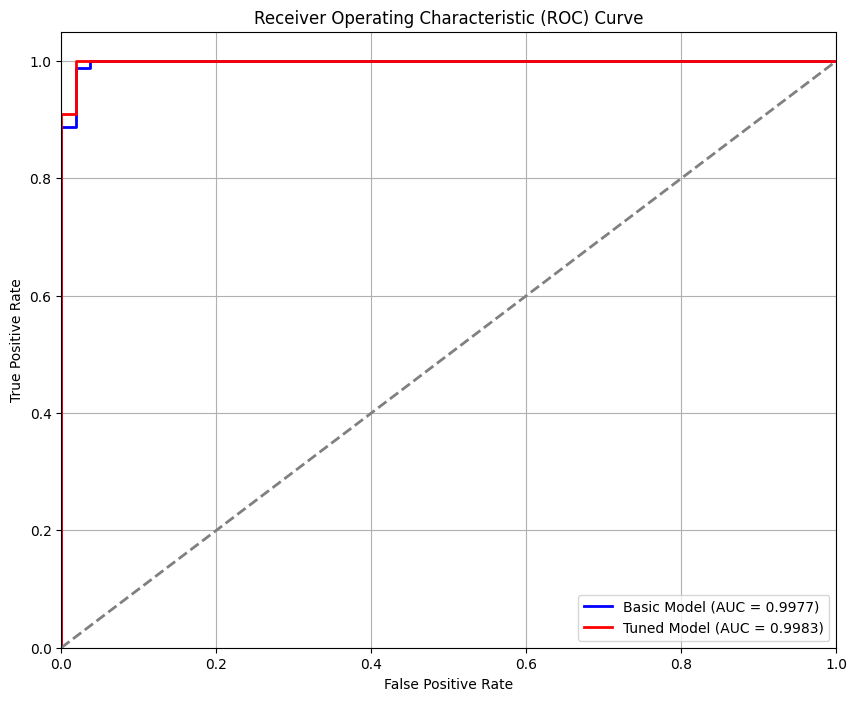

In [16]:
# Plot ROC curve
plt.figure(figsize=(10, 8))

# Calculate ROC curve for basic model
y_prob_basic = pipeline.predict_proba(X_test)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

# Calculate ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot both curves
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'Basic Model (AUC = {roc_auc_basic:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('Log_reg_roc_curve_comparison.png')
plt.show()
plt.close()

In [17]:
# Feature importance
final_model = best_model.named_steps['classifier']
if hasattr(final_model, 'coef_'):
    # Get feature importances (coefficients)
    importances = pd.DataFrame(
        final_model.coef_[0],
        index=feature_names,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importances.head(15)
    top_features['Coefficient'].plot(kind='barh', color='teal')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('Log_reg_feature_importance.png')
    plt.close()
    
    print("\n--- Top 10 Most Important Features ---")
    print(importances.head(10))
    print("\n--- Bottom 10 Least Important Features ---")
    print(importances.tail(10))


--- Top 10 Most Important Features ---
                         Coefficient
fractal dimension error     0.276883
compactness error           0.260757
mean fractal dimension      0.197714
symmetry error              0.194901
mean compactness            0.049021
texture error               0.021027
concavity error             0.012135
mean symmetry              -0.027783
smoothness error           -0.040739
worst fractal dimension    -0.089482

--- Bottom 10 Least Important Features ---
                      Coefficient
mean texture            -0.410436
worst perimeter         -0.414870
worst area              -0.426817
worst concavity         -0.433026
mean concave points     -0.463822
worst concave points    -0.470559
worst radius            -0.476696
worst symmetry          -0.477182
radius error            -0.484048
worst texture           -0.599928


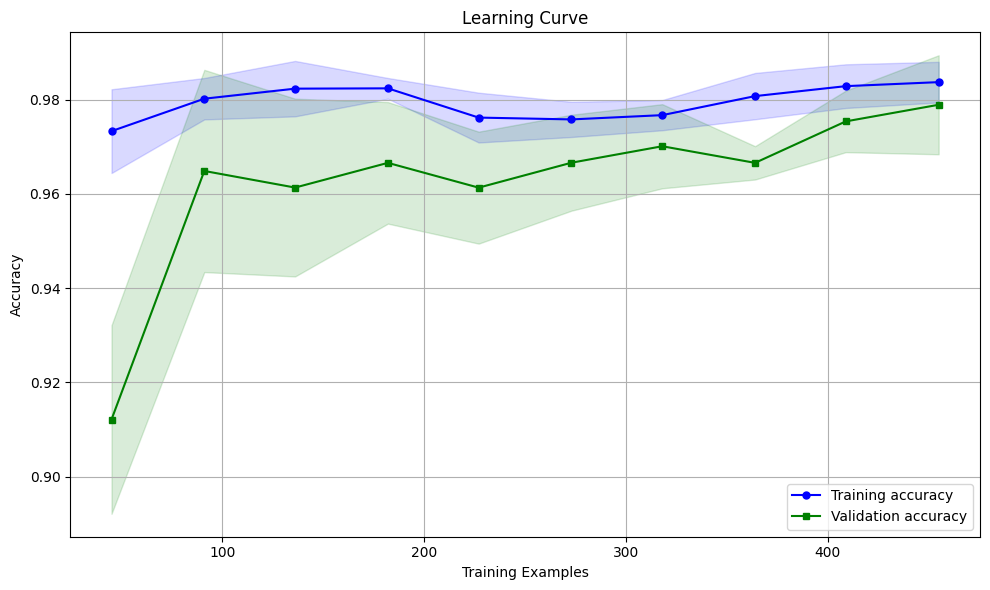

In [19]:
# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Log_reg_learning_curve.png')
plt.show()
plt.close()

In [20]:
# Function to check if model has converged
def check_convergence(model, X, y, max_iter=10000, tol=1e-6):
    """Test if model converges with higher max_iter and tighter tolerance"""
    if not hasattr(model, 'coef_'):
        return "Model doesn't have coefficient attribute"
    
    # Create a new model with same parameters but higher max_iter
    params = model.get_params()
    params['max_iter'] = max_iter
    params['tol'] = tol
    
    try:
        with warnings.catch_warnings(record=True) as w:
            test_model = LogisticRegression(**params)
            test_model.fit(X, y)
            if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                return f"Model still didn't converge with {max_iter} iterations"
            else:
                return f"Model converged with {max_iter} iterations and tol={tol}"
    except Exception as e:
        return f"Error testing convergence: {str(e)}"

In [21]:
# Test convergence with higher iterations if needed
if hasattr(tuned_model, 'n_iter_') and tuned_model.n_iter_ and tuned_model.n_iter_[0] >= tuned_model.max_iter:
    # If model used maximum iterations, test with higher value
    print("\n--- Testing Convergence with Higher Iterations ---")
    X_scaled = best_model.named_steps['scaler'].transform(X)
    convergence_result = check_convergence(tuned_model, X_scaled, y)
    print(convergence_result)
    
    print("\nSuggestions to address convergence issues:")
    print("1. Increase max_iter further (try 10000 or higher)")
    print("2. Try different solvers ('saga', 'lbfgs', 'newton-cg')")
    print("3. Adjust regularization strength")
    print("4. Scale features (already done in the pipeline)")
    print("5. Reduce feature dimensionality if appropriate")

print("\nAnalysis complete! The tuned model performance metrics, ROC curve, feature importance, and learning curve have been generated.")


Analysis complete! The tuned model performance metrics, ROC curve, feature importance, and learning curve have been generated.
